# Planewaves in Homogeneous Media

The eigenmode source can also be used to launch [planewaves](https://en.wikipedia.org/wiki/Plane_wave) in homogeneous media. The dispersion relation for a planewave is ω=|$\vec{k}$|/$n$ where ω is the angular frequency of the planewave and $\vec{k}$ its wavevector; $n$ is the refractive index of the homogeneous medium. This example demonstrates launching planewaves in a uniform medium with $n$ of 1.5 at three rotation angles: 0°, 20°, and 40°. Bloch-periodic boundaries via the `k_point` are used and specified by the wavevector $\vec{k}$. PML boundaries are used only along the x-direction.

First, we'll load our necesarry modules:

In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import h5py

Next, we'll create a function we can call multiple times that runs the simulation for different rotation angles:

In [2]:
# Simulation resolution and size
resolution = 20
sx, sy, sz = 4, 4, 8
cell_size = mp.Vector3(sx, sy, sz)

# Material properties
epsilon_substrate = 2.56  # corresponds to n = 1.6

# Geometry: lower half-space block
geometry = [
    mp.Block(
        center=mp.Vector3(0, -sy/4, 0),               # center halfway down in y < 0
        size=mp.Vector3(mp.inf, sy/2, mp.inf),        # fill y < 0
        material=mp.Medium(epsilon=epsilon_substrate)
    ),
    mp.Sphere(
    radius=1.0,
    center=mp.Vector3(0, 1, 0),
    material=mp.Medium(epsilon=epsilon_substrate)
    )
]

# Source: downward propagating plane wave
fcen = 1.0
df = 0.2
sources = [mp.Source(
    src=mp.GaussianSource(frequency=fcen, fwidth=df),
    component=mp.Ez,
    center=mp.Vector3(0, 6, 0),
    size=mp.Vector3(sx, 0, sz)
)]

# PML boundaries
pml_layers = [mp.PML(1.0)]

# Simulation setup
sim = mp.Simulation(
    cell_size=cell_size,
    resolution=resolution,
    boundary_layers=pml_layers,
    sources=sources,
    geometry=geometry,
    dimensions=3
)

# Run and output 3D Ez field to file for ParaView
sim.run(until=200)

# Get 3D Ez field at the current time step
ez_data = sim.get_array(center=mp.Vector3(), size=sim.cell_size, component=mp.Ez)

# Save Ez field to HDF5
with h5py.File("ez_field_angle_0.h5", "w") as f:
    f.create_dataset("Ez", data=ez_data)

print("✅ Ez field saved to ez_field_angle_0.h5")


-----------
Initializing structure...
time for choose_chunkdivision = 0.00232506 s
Working in 3D dimensions.
Computational cell is 4 x 4 x 8 with resolution 20
     block, center = (0,-1,0)
          size (1e+20,2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.56,2.56,2.56)
     sphere, center = (0,1,0)
          radius 1
          dielectric constant epsilon diagonal = (2.56,2.56,2.56)
time for set_epsilon = 17.6723 s
-----------


KeyboardInterrupt: 

Next we'll iterate over three rotation angles and plot their steady-state fields profiles. Residues of the backward-propagating waves due to the discretization are slightly visible.

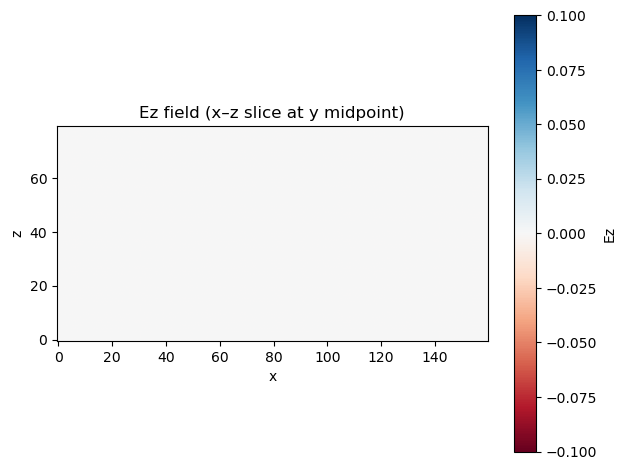

In [ ]:
# Load Ez field from HDF5
with h5py.File("ez_field_angle_0.h5", "r") as f:
    ez = f["Ez"][:]

# Plot a central y-slice (e.g., x–z plane at y = middle)
mid_y = ez.shape[1] // 2
plt.imshow(ez[:, mid_y, :], cmap="RdBu", origin="lower")
plt.title("Ez field (x–z slice at y midpoint)")
plt.colorbar(label="Ez")
plt.xlabel("x")
plt.ylabel("z")
plt.tight_layout()
plt.show()


In [ ]:
angle_deg = int(np.degrees(rot_angle_rad))

with h5py.File(f"ez_field_angle_{angle_deg}.h5", "w") as f:
    f.create_dataset("Ez", data=ez_data)

print(f"✅ Ez field for {angle_deg}° saved to ez_field_angle_{angle_deg}.h5")


In [ ]:
for rot_angle in np.radians([0, 20]):
    run_sim(rot_angle)

#paraview ez_3d_with_cylinder.h5

Note that this example involves a `ContinuousSource` for the time profile. For a pulsed source, the oblique planewave is incident at a given angle for only a *single* frequency component of the source. This is a fundamental feature of FDTD simulations and not of Meep per se. Thus, to simulate an incident planewave at multiple angles for a given frequency ω, you will need to do separate simulations involving different values of $\vec{k}$ (`k_point`) since each set of ($\vec{k}$,ω) specifying the Bloch-periodic boundaries and the frequency of the source will produce a different angle of the planewave. For more details, refer to Section 4.5 ("Efficient Frequency-Angle Coverage") in [Chapter 4](https://arxiv.org/abs/1301.5366) ("Electromagnetic Wave Source Conditions") of [Advances in FDTD Computational Electrodynamics: Photonics and Nanotechnology](https://www.amazon.com/Advances-FDTD-Computational-Electrodynamics-Nanotechnology/dp/1608071707).